In [28]:
from db_module import GetEvents
import pandas as pd
from pathlib import Path
import mplfinance as mpf

ModuleNotFoundError: No module named 'db_module'

In [15]:
df = pd.read_csv(Path("./Resources/BTC-5YRS-D.csv"), index_col="Date", parse_dates=True, infer_datetime_format=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
display(df.head())
display(df.tail())

,Open,Low,High,Close,Volume
Date,,,,,
2017-08-16,4261.48,4200.74,4485.39,4285.08,795.150377
2017-08-17,4285.08,3938.77,4371.52,4108.37,1199.888264
2017-08-18,4108.37,3850.00,4184.69,4139.98,381.309763
2017-08-19,4120.98,4032.62,4211.08,4086.29,467.083022
2017-08-20,4069.13,3911.79,4119.62,4016.00,691.743060


,Open,Low,High,Close,Volume
Date,,,,,
2021-10-07,53785.22,53617.61,56100.00,53951.43,46160.257850
2021-10-08,53955.67,53661.67,55489.00,54949.72,55177.080130
2021-10-09,54949.72,54080.00,56561.31,54659.00,89237.836128
2021-10-10,54659.01,54415.06,57839.04,57471.35,52933.165751
2021-10-11,57471.35,56588.00,57471.35,56999.12,4288.486640


In [16]:
df = df.dropna()

C:\Users\jpmad\anaconda3\envs\dev\lib\site-packages\mplfinance\_arg_validators.py:45: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


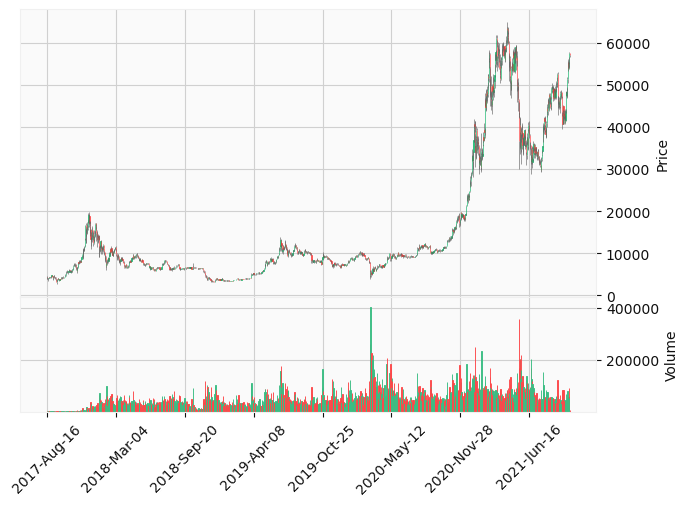

In [17]:
mpf.plot(df, type="candle", style="yahoo", volume=True)

In [24]:
events = db_strat.GetEvents(df)
new_df = events.Output()
new_df.head()

AttributeError: module 'db_strat' has no attribute 'GetEvents'

In [ ]:
class GetEvents:

    def __init__(self, df):
        self.df = df

    # Check if there is a previous bar
    def update_cert(self, cert, index, df):
        # Create certifying candle
        # count number of null values to see if is first row
        null_count = 0
        for value in cert.values():
            if value == None:
                null_count += 1
        
        # update prev dictionary if all null values
        # if first row it will update with those values
        if null_count == 5:
            cert['t'] = index
            cert['o'] = float(df.loc[index]['Open'])
            cert['c'] = float(df.loc[index]['Close'])
            cert['h'] = float(df.loc[index]['High'])
            cert['l'] = float(df.loc[index]['Low'])
            
            # return the certying candle dictionary
            return cert
        
        # update prev with new prev values (new prev is old curr)
        else:
            if index + datetime.timedelta(days=1):
                cert['t'] = (index)
                cert['o'] = float(df.loc[index]['Open'])
                cert['c'] = float(df.loc[index]['Close'])
                cert['h'] = float(df.loc[index]['High'])
                cert['l'] = float(df.loc[index]['Low'])
            
                # return the certying candle dictionary
                return cert
            
    def update_curr(self, curr, index, df):
        # Create current dictionary of current candle
        idx = df.index  
        
        # format datetime index
        dt_object = (index - datetime.timedelta(days=1)).to_datetime64()
        
        if sum(df.index == dt_object) > 0:
            index -= datetime.timedelta(days=1)
            curr['t'] = (index)
            curr['o'] = float(df.loc[index]['Open'])
            curr['c'] = float(df.loc[index]['Close'])
            curr['h'] = float(df.loc[index]['High'])
            curr['l'] = float(df.loc[index]['Low'])
            
            # return the current candle dictionary
            return curr
        else:
            pass
            
    def update_prev(self, prev, index, df):
        # Create the previous candle
        idx = df.index
        

        dt_object = (index - datetime.timedelta(days=2)).to_datetime64()

        if sum(df.index == dt_object) > 0:
            index -= datetime.timedelta(days=2)
            prev['t'] = (index)
            prev['o'] = float(df.loc[index]['Open'])
            prev['c'] = float(df.loc[index]['Close'])
            prev['h'] = float(df.loc[index]['High'])
            prev['l'] = float(df.loc[index]['Low'])
            
            # return the previous candle dictionary
            return prev
        else:
            pass

    def find_max(self, cert_candle, curr_candle, prev_candle):
        # get local max
        max_dict = {}
        if curr_candle and prev_candle:       
            if (curr_candle['c'] > cert_candle['c']) & (curr_candle['c'] > prev_candle['c']):
                max_dict = curr_candle
                return max_dict
            else:
                return None
            
    def find_min(self, cert_candle, curr_candle, prev_candle):   
        # get local min
        min_dict = {}
        if curr_candle and prev_candle:
            if (curr_candle['c'] < cert_candle['c']) & (curr_candle['c'] < prev_candle['c']):
                min_dict = curr_candle
                return min_dict
            else:
                return None

    def create_dataframe(self, df):
        """
        Create DataFrame with local minimums and maximums to create signals for double bottom creation
        Accepts DataFrames with columns formatted as 'Open', 'Close', 'High', 'Low'.
        More columns can be added.
        """
        
        # # store previous candle
        prev = {
            't' : None,
            'o' : None,
            'c' : None,
            'h' : None,
            'l' : None   
        }

        # store current candle
        curr = {
            't' : None,
            'o' : None,
            'c' : None,
            'h' : None,
            'l' : None 
        }

        # store certifying candle (certifies if the max/min is created)
        cert = {
            't' : None,
            'o' : None,
            'c' : None,
            'h' : None,
            'l' : None 
        }

        # Init lists for max and min events
        max_ = []
        min_ = []

        # Iterrate through dataframes indexes
        for index in df.index:
            cert_candle = update_cert(cert, index, df)
            curr_candle = update_curr(curr, index, df)
            prev_candle = update_prev(prev, index, df)

            # pont f arbitrary - 5 periods out
            # when finished will have 6 values
            mx = find_max(cert_candle, curr_candle, prev_candle)
            mn = find_min(cert_candle, curr_candle, prev_candle)

            # max stores close and high
            # min stores close and low
            if mx == None:
                max_.append(0)
            else:
                max_.append(1)

            if mn == None:
                min_.append(0)      
            else:
                min_.append(1)

        # Adding min/max events to original dataframe then creating a copy with columns for double bottom events
        max_min_df = pd.DataFrame({'Max': max_, 'Min': min_})
        max_min_df = max_min_df[['Max', 'Min']].shift(-1)
        max_min_df['Date'] = df.index
        max_min_df.set_index('Date', inplace=True)
        df_features = pd.concat([df, max_min_df], axis=1)
        df_features[['A', 'B', 'C', 'D', 'E', 'F', 'DB']] = 0.0
        
        return df_features

    def get_events(self, new_df):
        """Returns dataframe with binary encoded events"""
        
        new_df['Events'] = 0
        
        events_list = [None, None, None, None, None]
        search_c = {}
        
        buy = None
        sell = None
        
        total_events = 0
        
        for index in new_df.index:
            # Start search for A if A is none
            if events_list[0] == None:
                if new_df.loc[index]['Max'] == 1:
                    events_list[0] = index
                    new_df.loc[index]['A'] = 1.0
                    
            # Show that A exists
            elif events_list != None:
                new_df.loc[index]['A'] = 1.0
                
            # Reset if does not exist
            else:
                new_df.loc[index]['A'] = 0
                
            # Start search for B if B is none
            if (events_list[1] == None) & (events_list[0] != None):
                if new_df.loc[index]['Min'] == 1:
                    if new_df.loc[index]['Close'] < new_df.loc[events_list[0]]['Close']:
                        events_list[1] = index
                        new_df.loc[index]['B'] = 1.0
                        
            # Show that B exists
            elif events_list[1] != None:
                new_df.loc[index]['B'] = 1.0
                
            # Reset if does not exist    
            else:
                new_df.loc[index]['B'] = 0

            # Start search for C
            if (events_list[2] == None) & (events_list[1] != None) & (events_list[0] != None):
                if new_df.loc[index]['Max'] == 1:
                    
                    # Establish conditions
                    condition_1 = (new_df.loc[index]['Close'] > new_df.loc[events_list[1]]['Close'])
                    condition_2 = (new_df.loc[index]['Close'] < new_df.loc[events_list[0]]['Close'])
                    
                    # if C is in range between B and A
                    if condition_1 & condition_2:
                        events_list[2] = index
                        new_df.loc[index]['C'] = 1.0
                        
                    # if C is higher than A
                    elif new_df.loc[index]['Close'] > new_df.loc[events_list[0]]['Close']:
                        events_list = [events_list[0], None, None, None, None]
                        
            # Show if C exists
            elif events_list[2] != None:
                new_df.loc[index]['C'] = 1.0
                
            # Reset if does not exist   
            else:
                new_df.loc[index]['C'] = 0
                
            # Start search for D
            if (events_list[3] == None) & (events_list[2] != None) & (events_list[1] != None) & (events_list[0] != None):
                if new_df.loc[index]['Min'] == 1:   
                    
                    # Establish conditions
                    condition_1 = (new_df.loc[index]['Close'] < new_df.loc[events_list[1]]['Close'])
                    condition_2 = (new_df.loc[index]['Close'] > new_df.loc[events_list[1]]['Low'])
                    condition_3 = (new_df.loc[index]['Low'] < new_df.loc[events_list[1]]['Close'])
                    condition_4 = (new_df.loc[index]['Low'] > new_df.loc[events_list[1]]['Low'])
                    
                    # if D is in the range of B's low and close
                    if condition_1 & condition_2 | condition_3 & condition_4:
                        events_list[3] = index
                        new_df.loc[index]['D'] = 1
                        
                        # Search between B and D for highest max
                        for index in new_df.loc[events_list[1]:events_list[3]].index:
                            if new_df.loc[index]['Max'] == 1:
                                search_c[index] = new_df.loc[index]['Close']

                        # find max c value and add it to the events list
                        max_c = max(search_c, key = lambda x: search_c[x])
                        events_list[2] = max_c
                        max_c = max_c.to_datetime64()
                        new_df.loc[max_c]['C'] = 1

                    # if D is less than B's low
                    elif (new_df.loc[index]['Close'] < new_df.loc[events_list[1]]['Low']):
                        events_list = [max_c, None, None, None, None]
                        search_c = {}
                        
            # Show if D exists
            elif events_list[3] != None:
                new_df.loc[index]['D'] = 1.0
            
            # Reset if does not exist
            else:
                new_df.loc[index]['D'] = 0
                
            # start search E trade (entry)
            if (events_list[4] == None) & (events_list[3] != None) & (events_list[2] != None) & (events_list[1] != None) & (events_list[0] != None):
                if new_df.loc[index]['Close'] > new_df.loc[events_list[2]]['Close']:
                    events_list[4] = index
                    new_df.loc[index]['E'] = 1
                    new_df.loc[index]['DB'] = 1
                    
                    
                    if events_list[4] != None:
                        events_list = [None, None, None, None, None]
                        

                    
                # restart if close below D
                elif new_df.loc[index]['Close'] < new_df.loc[events_list[3]]['Low']:
                    display(events_list)
                    new_a = events_list[2]
                    events_list = [new_a, None, None, None, None]
                    search_c = {}
                    
            if new_df.loc[index]['DB'] == 1:
                buy = index
                sell = (index + datetime.timedelta(days=5)).to_datetime64()
                total_events += 1
                new_df.loc[index]['Events'] = total_events
                
            if sum(new_df.index == sell) > 0:
                new_df.loc[buy]['F'] = 0
                new_df.loc[sell]['F'] = float(new_df.loc[sell]['Close'] - new_df.loc[buy]['Close'])
                new_df.loc[sell]['DB'] = -1
                
            
            print(events_list)
            print(new_df.loc[index])
                
            
        return new_df

    def output(self):
        return self.get_events(self.create_dataframe(self.df))